# Hands on Bayesian modeling 

In this lesson we continue exploring the practical use of Bayesian modeling. 
We will first keep the technical aspects of inference process hidden, by focusing on model interpretation, sampling, and simulation. The maths behind approximated inference will be only sketched, and detailed in a second moment. 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

%run tools.py

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

<img src="San_Schmuck.JPG" alt="By Staehler - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=45076017" title="By Staehler - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=45076017" width="300"/>

In [72]:
data = pd.read_csv('Howell1.csv', sep = ';')
print(data[:10])

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0
5  163.830  62.992589  35.0     1
6  149.225  38.243476  32.0     0
7  168.910  55.479971  27.0     1
8  147.955  34.869885  19.0     0
9  165.100  54.487739  54.0     1


Which kind of relationship between height and weight do you think we could expect? We want find a Bayesian answer to this question.
We can start our investigation by considering only adult individuals.

In [39]:
data1 = data[data.age>=18]

We start by fitting a model for height only. Following what seen in the previous lesson we can reasonably assume that height is Gaussian distributed, as at the end it is the result of infinitesimal accumulations of growth during the life span. 
Therefore, for each subject $i$, we assument that his/her height is distributed as :

$$\mbox{height}_i\sim N(\mu,\sigma^2).$$

In particular, due to exchangeability, we also have 

$$p(\mbox{height}) = p(\mbox{height}_1, \mbox{height}_2, \ldots, \mbox{height}_N) = p(\mbox{height}_1)p(\mbox{height}_2)\cdots p(\mbox{height}_N),$$

which turns out to be a product of Gaussian likelihoods, as seen in the previous lesson.


Once agreed on the use of a Gaussian likelihood, we need to specify a prior. What could be a proper choice for the mean height? Of course, we can use a Gaussian model encoding our belief on average height in the population, and its variance. For example, by making this assumption:

$$ p(\mu) = N(178, 400),$$

we say that the average height is of $178cm$, with a variability of $\pm 2\sigma = [138cm, 218cm]$, which is a quite generous interval where to expect the mean to fall. For the variance, since we don't have really an optinion about it, we could simply say that it is uniformly distributed in the interval $[0cm,50cm]$:

$$\sigma = U(0,50).$$

In absence of observations, our model of height depends uniquely on our priors. We can simulate it by sampling:

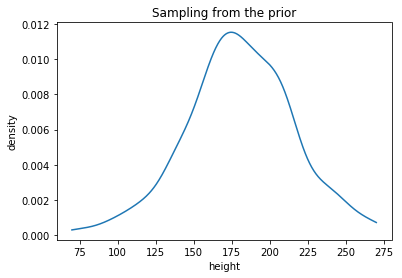

In [4]:
## A Gaussian model for height
# Sampling from the prior

sample_mu = norm.rvs( 178, 20, size = 1000)
sample_sigma = uniform.rvs( loc = 0, scale = 50, size = 1000)

prior_sample = [norm.rvs(sample_mu[i], sample_sigma[i]) for i in range(1000)]

data_density = gaussian_kde(prior_sample)
xs = np.linspace(70,270,1000)

plt.plot(xs, data_density(xs))
plt.title('Sampling from the prior')
plt.xlabel('height')
plt.ylabel('density')
plt.show()

We want now to integrate our data in the model, therefore we need to specify our likelihood:

$$p(y|\mu,\sigma^2) = N(y|\mu,\sigma^2).$$

**Exercise.** What would you need to modify in the code of the last lesson to compute the posterior with  the grid method?

Likelihood optima:
 μ = 154.83 
 σ2 = 20.00

Prior optima:
 μ = 176.55 
 σ2 = 0.10

Posterior optima:
 μ = 154.83 
 σ2 = 20.00


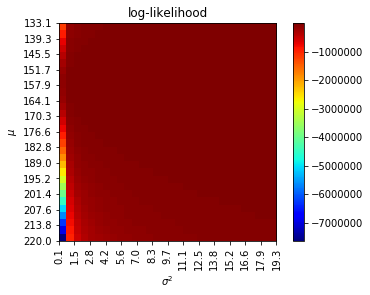

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


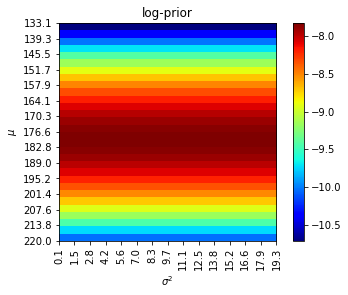

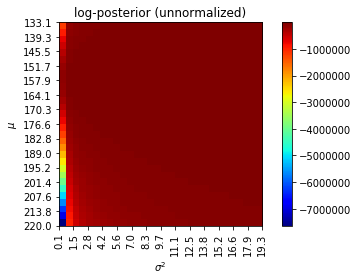

In [5]:
prior_mu_mean = 178
prior_mu_var = 400

prior_sigma_loc = 0
prior_sigma_scale = 50

prior_mu = norm(prior_mu_mean, np.sqrt(prior_mu_var))
prior_var = uniform(loc = prior_sigma_loc , scale = prior_sigma_scale)


from itertools import product

y = data1.height.values

# functions to compute log-likelihood and log-priors
def log_likelihood(params):
    # Assuming data exchangeability, we factorize the likelihood
    return np.sum([norm.logpdf(point,params[0],np.sqrt(params[1])) for point in y])

def log_prior(params):
    return prior_mu.logpdf(params[0])+ prior_var.logpdf(params[1])

# Estimating posterior 
# Uniform sampling parameters 
mu = np.linspace(130,220,30)
var = np.linspace(0.1,20,30)
# Creating a grid of parameters combinations
param_combinations = list(product(mu, var))

# We compute the (log-)likelihood and (log-)posterior for each combination of parameters
array_log_lik = np.array(list(map(log_likelihood, param_combinations))).reshape(len(mu),len(var))
array_log_prior = np.array(list(map(log_prior, param_combinations))).reshape(len(mu),len(var))

# We compute the unnormalized (log-)posterior
array_log_posterior = array_log_prior + array_log_lik 

# We identify the parameters' pair associated to the max of the posterior 
log_lik_optimum = (param_combinations[np.argmax(array_log_lik)])
prior_optimum = (param_combinations[np.argmax(array_log_prior)])
post_optimum = (param_combinations[np.argmax(array_log_posterior)])

print('Likelihood optima:\n \u03BC = {:.2f}'.format(log_lik_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(log_lik_optimum[1]) )

print('\nPrior optima:\n \u03BC = {:.2f}'.format(prior_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(prior_optimum[1]) )

print('\nPosterior optima:\n \u03BC = {:.2f}'.format(post_optimum[0]) 
      + ' \n \u03C32 = {:.2f}'.format(post_optimum[1]) )


ax0 = plt.gca()
img0 = ax0.imshow((array_log_lik), cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax0.set_xticks(np.linspace(0,1,int(len(var)/2)))
ax0.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax0.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax0.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-likelihood')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img0)
plt.show()


ax1 = plt.gca()
img1 = ax1.imshow((array_log_prior), cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax1.set_xticks(np.linspace(0,1,len(var)/2))
ax1.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax1.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax1.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-prior')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img1)
plt.show()


ax2 = plt.gca()
img2 = ax2.imshow(array_log_posterior, cmap='jet', interpolation='nearest', extent = [0,1,0,1])

ax2.set_xticks(np.linspace(0,1,int(len(var)/2)))
ax2.set_xticklabels([str(round(i,1)) for i in var[0::2]])
plt.xticks(rotation=90)

ax2.set_yticks(np.linspace(0,1,int(len(mu)/2)))
ax2.set_yticklabels([str(round(i,1)) for i in mu[::-1][0::2]])

plt.title('log-posterior (unnormalized)')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\sigma^2$')
plt.colorbar(img2)

plt.tight_layout()

plt.show()


At this point we have several ways of computing the posterior of our model, as we have seen during the last lesson. Unofrunately, the grid method tends to be very inefficient and inaccurate, and is therefore not the right choice in this case, since we start having a large number of observations. Also, we don't want to use the closed form that we derived for the Gaussian model, because we need to perform inference on $\sigma$ as well, and because we don't want to derive again all the maths each time we change the model.

For all these reason, we introduce here our first black-box machine for inference, that we call *Laplace approximation*. 
All we need to know now, is that this black-box takes the as input the priors and the likelihood of our model, and gives us back an approximation of the posterior under the form of a Gaussian distribution fitting our posterior parameter space. So, the posterior Gaussian will have dimension equal to the number of parameters.

Let's see this machine in action:

In [6]:
# We specify a likelihood N(\mu, \sigma^2)

# initial values for the parameters mu and sigma2
mu = 183.
sigma = 2.

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = 178
prior_mu_sigma = 20
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]


In [7]:
solution = laplace_solution([mu,sigma], [], data1.height, likelihood, [prior_mu, prior_sigma])

      fun: 1227.9161145881894
 hess_inv: array([[3.56801509e+00, 1.80046586e-02],
       [1.80046586e-02, 3.05045181e-03]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 165
      nit: 26
     njev: 40
   status: 0
  success: True
        x: array([154.60702362,   7.73133283])


It seems that the machine worked correctly, let's explore in detail what we obtained. 
The solution is composed by the mean and the covariance of the posterior, in our case for the parameters $\mu$ and $\sigma$.
We can therefore sample from the posterior to explore our new model of height:

In [8]:
solution_mean = solution[0]
solution_sigma = solution[1]

posterior_samples = multivariate_normal.rvs(solution_mean, solution_sigma, size = 1000)


**Exercise.** Compute mean, standard deviation and 85% interval for the posterior parameters.

In [9]:
# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'mu',1:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
mu     154.669590  1.939965  152.017505  157.367392
sigma    7.729102  0.056361    7.652344    7.809811


**Exercise.** Play around with the model, observe how the posterior changes in relation to the prior values.

In [10]:
# Using more informatve priors

# initial values for the parameters mu and sigma2
mu = 183.
sigma = 5.

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = 178
prior_mu_sigma = 0.1
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

solution2 = laplace_solution([mu,sigma], [], data1.height, likelihood, [prior_mu, prior_sigma])

      fun: 1629.108083772152
 hess_inv: array([[0.01012389, 0.02146606],
       [0.02146606, 1.30010391]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 18
     njev: 25
   status: 0
  success: True
        x: array([177.86375456,  24.51756158])


In [11]:
posterior_samples = multivariate_normal.rvs(solution2[0], solution2[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'mu',1:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
mu     177.863949  0.100648  177.715728  178.004971
sigma   24.509195  1.179975   22.758415   26.130434


**Exercise.** Play with priors and initialization to test the model, plot the results and compare them.

## Linear model

Now that we explored in detail the population height, we can finally start our studying on the relationship between weight and height.

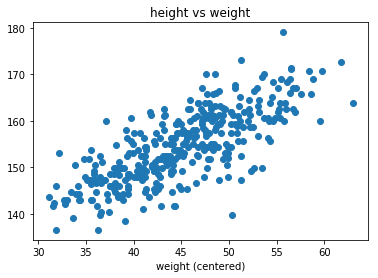

In [12]:
plt.scatter(data1.weight, data1.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

At this point need to increase a bit the complexity of out Bayesian model, as we are now performing a *regression*.
In particular, we are interested in the relationship:

$$\mbox{height} = a + b * \mbox{weight},$$

and we would like to obtain posterior distributions for the regression coefficients $a$ and $b$. As in classical regression models, the variable $a$ is called *intercept*, and expresses the age we expect when the weight is 0, and $b$ is the *slope*, which indicates how much the height changes for a unit increase of weight.

To proceed with our Bayesian treatment, the trick here is to assume that our previous Gaussian model of height is indeed dependent on the variable weight through this linear relationship. In this case, the height of an individual $i$ is a sample from a Gaussian model:

$$\mbox{height}_i\sim N(\mu_i,\sigma^2),$$

whiel this time we impose that $\mu_i = a + b * \mbox{weight}_i$. Note that while we allow the mean $\mu_i$ to vary depending on the weight, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across subjects.  
To completely define our Bayesian model, we need to specify priors for all the parameters we want to analyze:

$$ p(a) = N(178, 1000),$$

$$ p(b) = N(0, 100),$$

$$ p(\sigma) = U(0, 50).$$

We code all these elements to run our black-box machine:

In [26]:
expr = 'height ~   weight'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

And we are finally ready to perform inference:

In [27]:
solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)

      fun: 1083.700995967058
 hess_inv: array([[ 2.21576542e-04, -1.79801599e-03, -1.92452222e-04],
       [-1.79801599e-03,  4.86944143e+00,  5.26954043e-01],
       [-1.92452222e-04,  5.26954043e-01,  9.25533299e-02]])
      jac: array([1.52587891e-05, 1.52587891e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 482
      nit: 23
     njev: 94
   status: 2
  success: False
        x: array([154.59726372,   0.9050132 ,   5.0718663 ])


As before, we can sample from our posterior to explore the distribution of our model parameters: 

In [28]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
a      154.597751  0.014422  154.576918  154.618405
b        0.886788  2.170251   -2.203871    4.030561
sigma    5.061588  0.304811    4.617608    5.513109


We try to run the model again by centering the data, what is the difference in the posteriors? Can you explain this difference?

In [40]:
# Centering the data
mean_weight = np.mean(data1.weight)
data1.weight = data1.weight - mean_weight

# Fitting the model again
solution_regression_center = laplace_solution_regression(expr, data1, likelihood, priors)

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


      fun: 1083.700995967057
 hess_inv: array([[ 2.59336925e-02, -6.44222527e-04, -1.48338693e-02],
       [-6.44222527e-04,  1.78078221e-03,  5.12044886e-05],
       [-1.48338693e-02,  5.12044886e-05,  3.41286358e-02]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 130
      nit: 22
     njev: 26
   status: 0
  success: True
        x: array([154.59726374,   0.90501319,   5.07186598])


In [41]:
# Computing posterior samples
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_center, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_center, axis = 0)
# mean
post_mean = np.mean(posterior_samples_center, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      154.599604  0.162761  154.365287  154.840042
b        0.904562  0.042163    0.845584    0.967145
sigma    5.076232  0.183937    4.821347    5.333690


Once obtained the parameters, we can start exploring the model.
Let's plot the average prediction along the entire weight range:

[154.5996044    0.90456153   5.07623203]


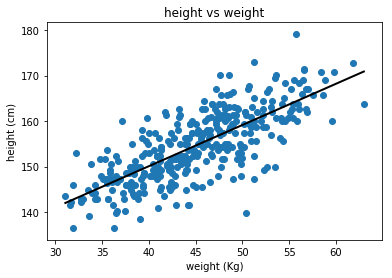

In [48]:
#plotting the average results 
print(post_mean)

x_range = np.linspace(min(data1.weight), max(data1.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.scatter(data1.weight + mean_weight,data1.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

Now we can explore the variability of the prediction, this can be done by using the posterior samples for the coefficients that we computed before:

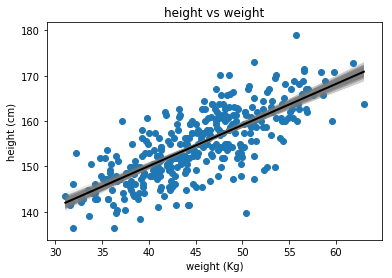

In [49]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_range
    plt.plot(x_range + mean_weight, prediction, lw = 0.05, color = 'grey')

plt.scatter(data1.weight + mean_weight,data1.height)
plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')


plt.show()

By following the same modeling procedure, we can study how the uncertainty on the estimation of the coefficients varies with the different sample sizes: 

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 71.32545922183903
 hess_inv: array([[ 1.07468991,  0.01737425,  0.01867769],
       [ 0.01737425,  0.01579053, -0.00227212],
       [ 0.01867769, -0.00227212,  0.54673939]])
      jac: array([0.00000000e+00, 2.86102295e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 202
      nit: 28
     njev: 40
   status: 0
  success: True
        x: array([153.55884723,   0.86866276,   4.7464605 ])


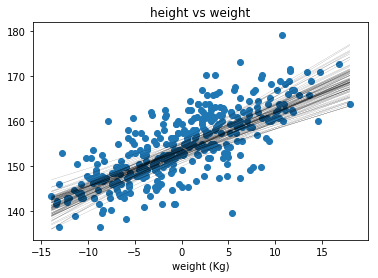

      fun: 161.31066747857892
 hess_inv: array([[ 4.81147112e-01,  1.16237440e-03, -5.50902601e-03],
       [ 1.16237440e-03,  9.31795866e-03, -2.84671219e-04],
       [-5.50902601e-03, -2.84671219e-04,  2.35422192e-01]])
      jac: array([ 5.72204590e-06,  0.00000000e+00, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 135
      nit: 23
     njev: 27
   status: 0
  success: True
        x: array([152.92545084,   0.88971199,   4.80911379])


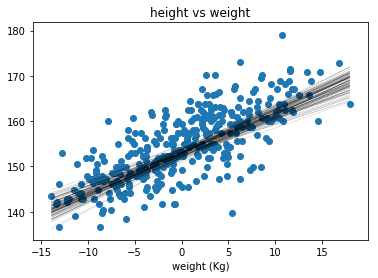

      fun: 478.3211606409028
 hess_inv: array([[ 0.19805005, -0.00237319, -0.00539057],
       [-0.00237319,  0.00407934, -0.00026768],
       [-0.00539057, -0.00026768,  0.09427134]])
      jac: array([-3.81469727e-06,  0.00000000e+00,  3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 125
      nit: 20
     njev: 25
   status: 0
  success: True
        x: array([153.8381323 ,   0.90193027,   5.42665158])


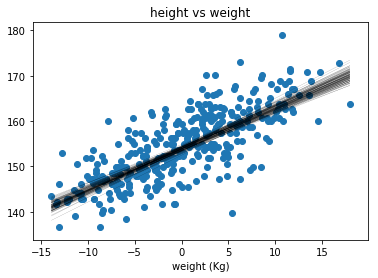

      fun: 1076.6635796350117
 hess_inv: array([[ 0.02368711, -0.00195742, -0.01441142],
       [-0.00195742,  0.00210173,  0.00065925],
       [-0.01441142,  0.00065925,  0.02781485]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 125
      nit: 17
     njev: 25
   status: 0
  success: True
        x: array([154.62813453,   0.91056837,   5.07189283])


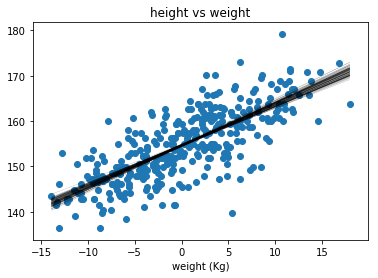

In [20]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Posterior uncertainty vs sample size

for N in [20,50,150,350]:
    
    # Selecting a subset of the data with sample size = N
    sub_data = data1.head(N)
    # Fitting the model again
    R = laplace_solution_regression(expr, sub_data, likelihood, priors)

    # Computing posterior samples
    post_R = multivariate_normal.rvs(R[0], R[1], size = 1000)

    for i in range(100):
        prediction = post_R[i,0] + post_R[i,1] * x_range
        plt.plot(x_range, prediction, lw = 0.1, color = 'black')

    plt.scatter(data1.weight,data1.height)
    plt.title('height vs weight')
    plt.ylabel('height (cm)')
    plt.xlabel('weight (Kg)')


    plt.show()  


The model also allows us to quantify the uncertainty of the prediction for a single odata point.
For example, for a person of 50Kg, the model gives us the following estimation:

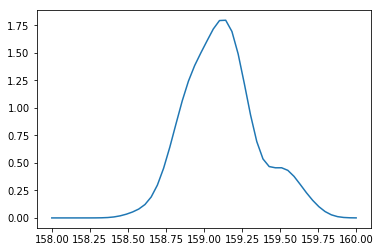

In [50]:
# Prediction for a person of 50Kg

x = 50
x_center = x - mean_weight


prediction = []
for i in range(100):
    prediction.append(posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_center)

data_density = gaussian_kde(prediction)
plt.plot(np.linspace(158,160), data_density(np.linspace(158,160)))
plt.show()

And we can repeat the exercise for the entire range of weights:

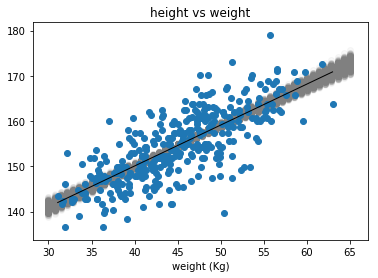

In [55]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight


prediction_range = []
N_s = len(posterior_samples_center[:,0])

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:,0] + posterior_samples_center[:,1] * x_)  

# Plotting the uncertainty
for i,x_ in enumerate(x_range_center):    
    plt.scatter(np.repeat(x_,N_s) + mean_weight, prediction_range[i], alpha = 0.05, color = 'grey')


#plotting the data
plt.scatter(data1.weight + mean_weight,data1.height)

# Plotting average prediction    
#avg_prediction = post_mean[0] + post_mean[1] * x_range_center
plt.plot(x_range + mean_weight, mean_prediction, lw = 1, color = 'black')

# Plotting +/- sigma theoretical interval
#plt.fill_between(x_range_center + mean_weight, mean_prediction - post_mean[2], mean_prediction + post_mean[2], alpha=0.1, color = 'green', linestyle='dashdot')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

plt.show()

So far we analyzed only the uncertainty related to the mean prediction, but we see that many data points fall clearly beyond the confidence interval.  
We can estimate the overall posterior uncertainty of the prediction, while accounting for the estimated regression noise. 
This requires to sample from the data posterior, accounting for the variability for both regression coefficients and modelled noise:

[]

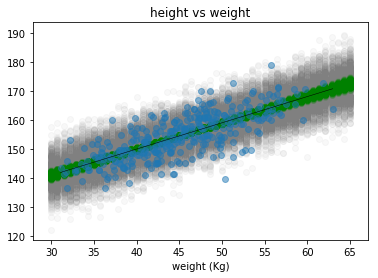

In [56]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range_noise.append(norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  posterior_samples_center[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data1.weight + mean_weight,data1.height, alpha = 0.5)
plt.plot(x_range + mean_weight, mean_prediction, lw = 0.5, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.plot()

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 

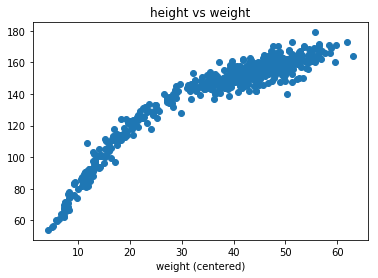

In [73]:
mean_tot_weight = np.mean(data.weight)

data.weight = data.weight - mean_tot_weight

plt.scatter(data.weight + mean_tot_weight, data.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

Which kind of model would you use for modeling this data?

In [74]:
data['weight2'] = data.weight * data.weight

expr = 'height ~   weight + weight2'

print(data.head(10))

    height     weight   age  male     weight2
0  151.765  12.214989  63.0     1  149.205954
1  139.700   0.875189  63.0     0    0.765956
2  136.525  -3.745780  65.0     0   14.030865
3  156.845  17.431297  41.0     1  303.850112
4  145.415   5.666254  51.0     0   32.106439
5  163.830  27.381971  35.0     1  749.772358
6  149.225   2.632858  32.0     0    6.931941
7  168.910  19.869354  27.0     1  394.791225
8  147.955  -0.740733  19.0     0    0.548685
9  165.100  18.877121  54.0     1  356.345713


In [75]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_b2_mean = 0
prior_b2_sigma = 10
prior_b2 = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_b2, prior_sigma]


solution_regression_quadratic = laplace_solution_regression(expr, data, likelihood, priors)


      fun: 1738.9532047374819
 hess_inv: array([[ 1.29756926e-01, -3.45422696e-03, -3.13144449e-04,
         6.45154695e-02],
       [-3.45422696e-03,  4.00765426e-04,  1.31202135e-05,
        -1.71273504e-03],
       [-3.13144449e-04,  1.31202135e-05,  1.40315631e-06,
        -1.55048469e-04],
       [ 6.45154695e-02, -1.71273504e-03, -1.55048469e-04,
         3.21013649e-02]])
      jac: array([ 0.00000000e+00,  0.00000000e+00, -1.83105469e-04, -4.57763672e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 289
      nit: 33
     njev: 48
   status: 2
  success: False
        x: array([ 1.46671414e+02,  1.45466311e+00, -3.88570049e-02,  5.74977463e+00])


In [76]:
# Computing posterior samples
posterior_samples_quadratic = multivariate_normal.rvs(solution_regression_quadratic[0], solution_regression_quadratic[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_quadratic, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_quadratic, axis = 0)
# mean
post_mean = np.mean(posterior_samples_quadratic, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'b2', 3:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      146.652809  0.367584  146.109512  147.192196
b        1.454965  0.020034    1.426315    1.484040
b2      -0.038826  0.001215   -0.040593   -0.037015
sigma    5.740443  0.182332    5.472583    6.006372


[ 1.46652809e+02  1.45496464e+00 -3.88257921e-02  5.74044268e+00]


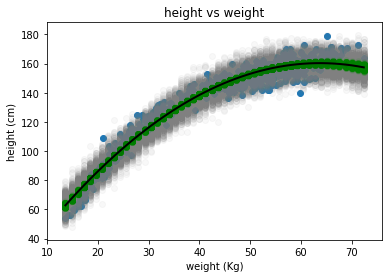

In [81]:
#plotting the average results 
x_range = np.linspace(min(data.weight), max(data.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range + post_mean[2] * x_range**2

plt.plot(x_range + mean_weight , mean_prediction, lw = 2, color = 'black')
plt.scatter(data.weight + mean_weight, data.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range.append(posterior_samples_quadratic[:500,0] + posterior_samples_quadratic[:500,1] * x_ + posterior_samples_quadratic[:500,2] * x_**2)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    pred_mean_data = posterior_samples_quadratic[:500,0] + posterior_samples_quadratic[:500,1] * x_ + posterior_samples_quadratic[:500,2] * x_**2
    prediction_range_noise.append(norm.rvs( pred_mean_data,  posterior_samples_quadratic[:500,3]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.show()

In [24]:
expr = 'height ~   weight + weight2'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_c_mean = 0
prior_c_sigma = 10
prior_c = ['gaussian', [prior_c_mean, prior_c_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_c, prior_sigma]

solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 1086.5773229446681
 hess_inv: array([[ 5.53170043e-02,  4.25240085e-03, -1.08896793e-03,
        -3.28977384e-02],
       [ 4.25240085e-03,  2.32739529e-03, -6.10650099e-05,
        -2.21403478e-03],
       [-1.08896793e-03, -6.10650099e-05,  5.78640895e-05,
         6.81529987e-04],
       [-3.28977384e-02, -2.21403478e-03,  6.81529987e-04,
         3.15060685e-02]])
      jac: array([ 1.52587891e-05,  1.52587891e-05, -1.52587891e-05,  1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 597
      nit: 35
     njev: 96
   status: 2
  success: False
        x: array([1.54009194e+02, 9.11125679e-01, 1.42949606e-02, 5.06687387e+00])
